## Downloading Data

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedabdallah98","key":"05df623b311b1a8123f43cce3e4e80a2"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c fake-news

 71% 33.0M/46.5M [00:00<00:00, 139MB/s] 
100% 46.5M/46.5M [00:00<00:00, 150MB/s]


In [5]:
!mkdir Datasets
!unzip fake-news.zip -d Datasets

Archive:  fake-news.zip
  inflating: Datasets/submit.csv     
  inflating: Datasets/test.csv       
  inflating: Datasets/train.csv      


## Import libraries

In [1]:
import numpy as np
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")


import itertools
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental import RandomFourierFeatures
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Embedding, Activation, LSTM

# Reading Data and EDA

In [3]:
data = pd.read_csv('/content/Datasets/train.csv')

In [4]:
data.dropna(inplace =True)

In [5]:
X=data.drop(columns=['label'])

In [6]:
y = data['label']

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18285 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18285 non-null  int64 
 1   title   18285 non-null  object
 2   author  18285 non-null  object
 3   text    18285 non-null  object
dtypes: int64(1), object(3)
memory usage: 714.3+ KB


In [8]:
voc_size=5000

# Preprocessing

In [9]:
news_msg = data.copy()


In [10]:
news_msg.reset_index(inplace = True)

In [11]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(news_msg)):
    review = re.sub('[^a-zA-Z]', ' ', news_msg['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

### One Hot Representation

In [12]:
one_hot_rep=[one_hot(words,voc_size)for words in corpus] 
one_hot_rep

[[4539, 4626, 839, 4430, 3933, 535, 3132, 499, 4992, 3079],
 [2021, 2744, 688, 3470, 4334, 4338, 4374],
 [1863, 3183, 1250, 2893],
 [2236, 3987, 2274, 832, 4609, 1032],
 [1907, 4334, 2640, 3301, 4763, 2595, 4334, 2157, 592, 4414],
 [3508,
  1043,
  1584,
  2120,
  2513,
  1627,
  3553,
  3432,
  2092,
  2762,
  3689,
  1009,
  2278,
  2704,
  4374],
 [320, 1682, 4242, 3134, 923, 448, 2686, 2369, 2173, 2908, 279],
 [2549, 3749, 1842, 3880, 1541, 4950, 1627, 9, 2173, 2908, 279],
 [3559, 4317, 119, 2043, 2596, 2075, 3858, 72, 1627, 4954],
 [932, 1379, 675, 144, 703, 2158, 31, 3910],
 [3320, 1834, 4386, 3498, 2507, 3629, 4034, 382, 2589, 4803, 772],
 [832, 863, 3933, 2075, 1627, 1541],
 [4708, 2956, 3103, 369, 4850, 3233, 3793, 2299, 3211],
 [4415, 2700, 2900, 4245, 3442, 3000, 827, 2173, 2908, 279],
 [1722, 4745, 211, 2925, 1286, 2173, 2908, 279],
 [4183, 2256, 226, 2733, 3074, 2564, 2298, 4445, 3477, 3021],
 [1880, 1248, 2744],
 [1814, 1192, 4514, 569, 1627, 607, 1191, 4374],
 [76, 4108,

### Word_Embedding

In [13]:
sent_length=20
embedded_words=pad_sequences(one_hot_rep,padding='pre',maxlen=sent_length)
print(embedded_words)

[[   0    0    0 ...  499 4992 3079]
 [   0    0    0 ... 4334 4338 4374]
 [   0    0    0 ... 3183 1250 2893]
 ...
 [   0    0    0 ... 2173 2908  279]
 [   0    0    0 ... 3291  519  771]
 [   0    0    0 ... 1027 4209 4948]]


## Splitting Data

In [14]:
np.array(embedded_words),np.array(y)

(array([[   0,    0,    0, ...,  499, 4992, 3079],
        [   0,    0,    0, ..., 4334, 4338, 4374],
        [   0,    0,    0, ..., 3183, 1250, 2893],
        ...,
        [   0,    0,    0, ..., 2173, 2908,  279],
        [   0,    0,    0, ..., 3291,  519,  771],
        [   0,    0,    0, ..., 1027, 4209, 4948]], dtype=int32),
 array([1, 0, 1, ..., 0, 1, 1]))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(np.array(embedded_words),np.array(y), test_size=0.33, random_state=42)

## Applying Model : LSTM

In [16]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))

model.add(BatchNormalization())
model.add(LSTM(85))

model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=.001),metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 batch_normalization (BatchN  (None, 20, 40)           160       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 85)                42840     
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense (Dense)               (None, 1)                 86        
                                                                 
Total params: 243,086
Trainable params: 243,006
Non-trainable params: 80
_________________________________________________

In [18]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=32)

Epoch 1/15
383/383 [==============================] - 14s 29ms/step - loss: 0.2244 - accuracy: 0.9020 - val_loss: 0.3498 - val_accuracy: 0.8795
Epoch 2/15
383/383 [==============================] - 10s 26ms/step - loss: 0.1015 - accuracy: 0.9624 - val_loss: 0.1987 - val_accuracy: 0.9231
Epoch 3/15
383/383 [==============================] - 10s 26ms/step - loss: 0.0449 - accuracy: 0.9855 - val_loss: 0.2589 - val_accuracy: 0.9165
Epoch 4/15
383/383 [==============================] - 11s 30ms/step - loss: 0.0203 - accuracy: 0.9931 - val_loss: 0.3223 - val_accuracy: 0.9186
Epoch 5/15
383/383 [==============================] - 10s 27ms/step - loss: 0.0130 - accuracy: 0.9953 - val_loss: 0.3896 - val_accuracy: 0.9186
Epoch 6/15
383/383 [==============================] - 11s 29ms/step - loss: 0.0085 - accuracy: 0.9976 - val_loss: 0.3892 - val_accuracy: 0.9178
Epoch 7/15
383/383 [==============================] - 10s 27ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.4560 - val_accuracy:

In [19]:
y_pred=model.predict(X_test)

189/189 [==============================] - 2s 7ms/step


###Evaluation

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
f = y_pred>.5
y_pred=np.multiply(f, 1)

In [22]:
y_pred

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3419
           1       0.89      0.92      0.90      2616

    accuracy                           0.91      6035
   macro avg       0.91      0.92      0.91      6035
weighted avg       0.92      0.91      0.91      6035

******************************************************************************************************************************************************

Accuracy score is  0.9148301574150787 

******************************************************************************************************************************************************

Confusion matrix, without normalization


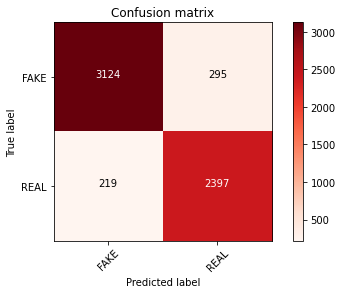

In [23]:
print(classification_report(y_test, y_pred))
print(150 * '*'+'\n')
score=accuracy_score(y_test,y_pred)
print("Accuracy score is " , score ,'\n')
print(150 * '*'+'\n')
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['FAKE','REAL']);

# Mix of LSTM (used as a feature extractor) and SVM

## Let's try to extract features learned by the LSTM layer and pass it to an SVM layer :

#### 1. After training the LSTM within the whole Network :

In [26]:
lay_name = 'lstm'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(lay_name).output)
intermediate_output = intermediate_layer_model(X_train)

In [28]:
X_feat_extracted = np.array(intermediate_output)

In [30]:
model_svm= SVC(C=25,gamma=.05,kernel='rbf',probability=True)
model_svm.fit(X_feat_extracted, y_train)

SVC(C=25, gamma=0.05, probability=True)

In [31]:
y_pred_mix = model_svm.predict(intermediate_layer_model(X_test))
accuracy_score(y_test,y_pred_mix)

0.9146644573322287

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      3419
           1       0.88      0.92      0.90      2616

    accuracy                           0.91      6035
   macro avg       0.91      0.92      0.91      6035
weighted avg       0.92      0.91      0.91      6035

******************************************************************************************************************************************************

Accuracy score is  0.9146644573322287 

******************************************************************************************************************************************************

Confusion matrix, without normalization


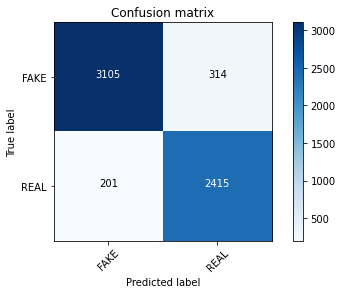

In [34]:
print(classification_report(y_test, y_pred_mix))
print(150 * '*'+'\n')
score=accuracy_score(y_test,y_pred_mix)
print("Accuracy score is " , score ,'\n')
print(150 * '*'+'\n')
cm = confusion_matrix(y_test, y_pred_mix)
plot_confusion_matrix(cm, classes=['FAKE','REAL'],cmap=plt.cm.Blues);

#### 2. Extracting features output from LSTM without any training to the Network on the task

In [24]:
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))

model1.add(BatchNormalization())
model1.add(LSTM(85))

model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))

In [25]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            200000    
                                                                 
 batch_normalization_1 (Batc  (None, 20, 40)           160       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 85)                42840     
                                                                 
 dropout_1 (Dropout)         (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 86        
                                                                 
Total params: 243,086
Trainable params: 243,006
Non-trainable params: 80
_______________________________________________

In [27]:
layer_name = 'lstm_1'
intermediate_layer_model1 = keras.Model(inputs=model1.input,
                                       outputs=model1.get_layer(layer_name).output)
intermediate_output_1 = intermediate_layer_model1(X_train)

In [29]:
X_feat_extracted_1 = np.array(intermediate_output_1)

In [46]:
model_svm_1= SVC(C=100,gamma=.1,kernel='rbf',probability=True)
model_svm_1.fit(X_feat_extracted_1, y_train)

SVC(C=100, gamma=0.1, probability=True)

In [47]:
y_pred_mix_1 = model_svm_1.predict(intermediate_layer_model1(X_test))
accuracy_score(y_test,y_pred_mix_1)

0.8646230323115162

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      3419
           1       0.82      0.89      0.85      2616

    accuracy                           0.86      6035
   macro avg       0.86      0.87      0.86      6035
weighted avg       0.87      0.86      0.87      6035

******************************************************************************************************************************************************

Accuracy score is  0.8646230323115162 

******************************************************************************************************************************************************

Confusion matrix, without normalization


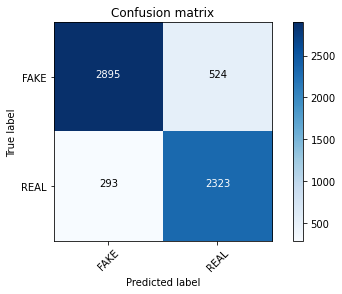

In [48]:
print(classification_report(y_test, y_pred_mix_1))
print(150 * '*'+'\n')
score=accuracy_score(y_test,y_pred_mix_1)
print("Accuracy score is " , score ,'\n')
print(150 * '*'+'\n')
cm = confusion_matrix(y_test, y_pred_mix_1)
plot_confusion_matrix(cm, classes=['FAKE','REAL'],cmap=plt.cm.Blues);

## Quasi_SVM Neural Network :

In [59]:
Quasi_svm_NN = Sequential()
Quasi_svm_NN.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
Quasi_svm_NN.add(LSTM(75))
Quasi_svm_NN.add(Dropout(0.4))
Quasi_svm_NN.add(RandomFourierFeatures(output_dim=16, scale=10.0, kernel_initializer="gaussian" ))
Quasi_svm_NN.add(Dense(1,activation='sigmoid'))

In [60]:
Quasi_svm_NN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 40)            200000    
                                                                 
 lstm_4 (LSTM)               (None, 75)                34800     
                                                                 
 dropout_4 (Dropout)         (None, 75)                0         
                                                                 
 random_fourier_features_2 (  (None, 16)               1217      
 RandomFourierFeatures)                                          
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 236,034
Trainable params: 234,817
Non-trainable params: 1,217
____________________________________________

In [61]:
Quasi_svm_NN.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.hinge,
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)

In [62]:
Quasi_svm_NN.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=32)

Epoch 1/15
383/383 [==============================] - 14s 29ms/step - loss: 0.8003 - acc: 1.0000 - val_loss: 0.6694 - val_acc: 1.0000
Epoch 2/15
383/383 [==============================] - 9s 24ms/step - loss: 0.6476 - acc: 1.0000 - val_loss: 0.6533 - val_acc: 1.0000
Epoch 3/15
383/383 [==============================] - 9s 24ms/step - loss: 0.6232 - acc: 1.0000 - val_loss: 0.6462 - val_acc: 1.0000
Epoch 4/15
383/383 [==============================] - 9s 24ms/step - loss: 0.6159 - acc: 1.0000 - val_loss: 0.6451 - val_acc: 1.0000
Epoch 5/15
383/383 [==============================] - 9s 23ms/step - loss: 0.6092 - acc: 1.0000 - val_loss: 0.6442 - val_acc: 1.0000
Epoch 6/15
383/383 [==============================] - 9s 22ms/step - loss: 0.6011 - acc: 1.0000 - val_loss: 0.6482 - val_acc: 1.0000
Epoch 7/15
383/383 [==============================] - 8s 22ms/step - loss: 0.5985 - acc: 1.0000 - val_loss: 0.6425 - val_acc: 1.0000
Epoch 8/15
383/383 [==============================] - 10s 25ms/step 

In [63]:
y_pred_quasi=Quasi_svm_NN.predict(X_test)

189/189 [==============================] - 2s 6ms/step


## Evaluation :

In [64]:
o = y_pred_quasi>.5
y_pred_quasi = np.multiply(o, 1)

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3419
           1       0.89      0.92      0.91      2616

    accuracy                           0.92      6035
   macro avg       0.91      0.92      0.92      6035
weighted avg       0.92      0.92      0.92      6035

******************************************************************************************************************************************************

Accuracy score is  0.9171499585749793 

******************************************************************************************************************************************************

Confusion matrix, without normalization


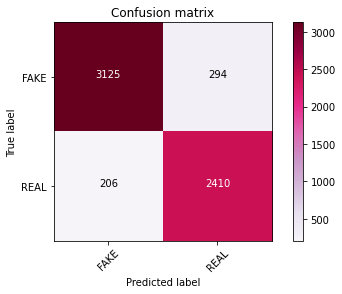

In [73]:
print(classification_report(y_test, y_pred_quasi))
print(150 * '*'+'\n')
score=accuracy_score(y_test,y_pred_quasi)
print("Accuracy score is " , score ,'\n')
print(150 * '*'+'\n')
cm = confusion_matrix(y_test, y_pred_quasi)
plot_confusion_matrix(cm, classes=['FAKE','REAL'],cmap=plt.cm.PuRd);